## Combined

In [1]:
import spacy
nlp = spacy.load('en') # this should take some time like 10s to load
%load_ext line_profiler

In [33]:
from collections import Counter, defaultdict
from datetime import datetime

import numpy as np
import scipy as sp
from scipy.sparse import coo_matrix, hstack
import pandas as pd
import nltk
from spacy.tokens.doc import Doc

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction import DictVectorizer

In [5]:
test_loc = 'test_dump.bin'
train_loc = 'train_dump.bin'
invalids = ['PUNCT', 'X', 'EOL', 'SPACE']

## Read Training

In [4]:
docs = []
i = 0
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
with open(train_loc, 'rb') as file_:
    for byte_string in Doc.read_bytes(file_):
        if i%10000 == 0: print i, datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        docs.append(Doc(nlp.vocab).from_bytes(byte_string))
        i += 1
#         if i == 10: break
print datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(type(docs[0]))

2017-05-16 00:45:05
0 2017-05-16 00:45:05
10000 2017-05-16 00:45:14
20000 2017-05-16 00:45:17
30000 2017-05-16 00:45:20
40000 2017-05-16 00:45:22
50000 2017-05-16 00:45:26
60000 2017-05-16 00:45:29
70000 2017-05-16 00:45:31
80000 2017-05-16 00:45:33
90000 2017-05-16 00:45:34
100000 2017-05-16 00:45:36
110000 2017-05-16 00:45:37
120000 2017-05-16 00:45:37
130000 2017-05-16 00:45:38
140000 2017-05-16 00:45:39
150000 2017-05-16 00:45:40
160000 2017-05-16 00:45:40
170000 2017-05-16 00:45:41
180000 2017-05-16 00:45:42
190000 2017-05-16 00:45:43
200000 2017-05-16 00:45:44
210000 2017-05-16 00:45:45
220000 2017-05-16 00:45:46
230000 2017-05-16 00:45:47
240000 2017-05-16 00:45:47
250000 2017-05-16 00:45:48
260000 2017-05-16 00:45:49
270000 2017-05-16 00:45:50
280000 2017-05-16 00:45:51
290000 2017-05-16 00:45:52
300000 2017-05-16 00:45:53
310000 2017-05-16 00:45:54
320000 2017-05-16 00:45:56
330000 2017-05-16 00:45:57
340000 2017-05-16 00:45:58
350000 2017-05-16 00:45:58
360000 2017-05-16 00:4

In [11]:
train = pd.read_csv('../data/train.csv')
# test = pd.read_csv('../data/test.csv')
# print train.shape, test.shape
target = train['is_duplicate']

## Prelims

In [29]:
def prepareDoc(doc):
    return [w.lemma_ for w in doc if not w.is_stop and w.pos not in invalids]

In [28]:
unigramCounts = Counter([d for doc in docs for d in prepareDoc(doc)])
bigramCounts = Counter([d for doc in docs for d in nltk.bigrams(prepareDoc(doc))])
trigramCounts = Counter([d for doc in docs for d in nltk.ngrams(prepareDoc(doc), 3)])

## BOW

In [51]:
def bow(docs):
    fvs = []
    for i in range(0,len(docs),2):
        if i % 100000 == 0: print i
        fv = {}
        d1 = docs[i]
        d2 = docs[i+1]
        
        w1 = [word.lemma_ for word in d1 if not word.is_stop and word.pos is not 95]
        w2 = [word.lemma_  for word in d2 if not word.is_stop and word.pos_ is not 95]
        
        s1 = set([word.lemma_ for word in d1 if not word.is_stop and word.pos_ is not 95])
        s2 = set([word.lemma_  for word in d2 if not word.is_stop and word.pos_ is not 95])
        
        diff = s1 ^ s2
        same =  s1 & s2

        same = Counter([w for w in same])
        fv.update(same)

        diff = Counter([w + '_d' for w in diff])
        fv.update(diff)

        fvs.append(fv)
        
    return fvs

In [52]:
fvsbow = wordPairs(docs)

0
100000
200000
300000
400000
500000
600000
700000
800000


In [23]:
from sklearn.feature_extraction.text import TfidfTransformer
v = DictVectorizer()
t = TfidfTransformer(smooth_idf=False)

In [62]:
Xbow = v.fit_transform(fvsbow)
# X = t.fit_transform(counts)

## Validation

In [25]:
clfs = [MultinomialNB(alpha=1), SGDClassifier(loss='log'), LogisticRegression(), RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=50, min_samples_split=30, min_samples_leaf=8, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=-1, warm_start=True, class_weight=None)]
n_classes = 2
for clf in clfs:
    print clf
    scores = cross_val_score(clf, X, target, cv=3, scoring='neg_log_loss')
    print "Log Loss: %0.5f" % scores.mean()

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
Log Loss: -0.52641
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Log Loss: -0.45891
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Log Loss: -0.41325
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, rand

### ROC

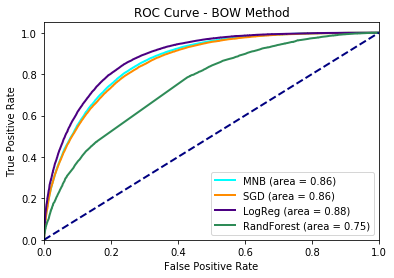

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)
clfs = [('MNB', MultinomialNB(alpha=1)), ('SGD', SGDClassifier(loss='log')), ('LogReg', LogisticRegression()), ('RandForest', RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=50, min_samples_split=30, min_samples_leaf=8))]

colors = cycle(['cyan', 'darkorange','indigo', 'seagreen', 'blue', ])

for (clfname, clf), color in zip(clfs, colors):
    y_score = zip(*clf.fit(X_train, y_train).predict_proba(X_test))[1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    rocauc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color=color, lw=lw, label=clfname + ' (area = %0.2f)' % rocauc)
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BOW Method')
plt.legend(loc="lower right")
plt.savefig("roc.pdf")
plt.show()

## WC

### Helper Functions

In [36]:
def tfidf(w, corpus):
    if w in corpus and corpus[w] is not 0: return 1/float(corpus[w])
    else: return 0
def getOverlaps(sentence1, sentence2):
    s1 = set(sentence1)
    s2 = set(sentence2)
    return s1 & s2, s1 ^ s2, s1 | s2
def tupleCounter(l):
    d = defaultdict(int) 
    for t in l:
        d[t[0]] += t[1]
    return d
def covertPropn(pos):
#     if pos == u'PROPN' or pos == u'PRON':
#         return u'NOUN'
#     if pos == u'ADP': return u'ADV'
#     else: return pos
    return pos

In [37]:
def countQuestionPairs(docs):
    
    fvs = []
    for i in range(0,len(docs),2):
        if i % 100000 == 0: print i
        fv = defaultdict(int) 
        d1 = docs[i]
        d2 = docs[i+1]

        s1 = set(list(str(e).lower() for e in d1.ents))
        s2 = set(list(str(e).lower() for e in d2.ents))
        
        w1 = [w for w in d1 if not w.is_stop and w.pos not in invalids]
        w2 = [w for w in d2 if not w.is_stop and w.pos not in invalids]
        
        p1 = [(covertPropn(word.pos_), word.lemma_) for word in w1]
        p2 = [(covertPropn(word.pos_), word.lemma_) for word in w2]
        
        u1 = [word.lemma_ for word in w1]
        u2 = [word.lemma_ for word in w2]
        
        total = float(len(u1) + len(u2))
        sameents = s1 & s2
        diffents = s1 ^ s2
        if len(sameents) > 0:
            fv['sameents'] = np.sum([tfidf(w, unigramCounts) for w in sameents])
        if len(diffents) > 0:
            fv['diffents'] = np.sum([tfidf(w, unigramCounts) for w in diffents])
        
        psame, pdiff, ptotal = getOverlaps(p1, p2)
        usame, udiff, utotal = getOverlaps(u1, u2)
        bsame, bdiff, btotal = getOverlaps(nltk.bigrams(u1), nltk.bigrams(u2))        
        tsame, tdiff, ttotal = getOverlaps(nltk.ngrams(u1,3),nltk.ngrams(u2,3))
#         fv['total'] = total
        fv['usame'] = len(usame)
        fv['udiff'] = len(udiff)
        if len(usame) > 0:
            fv['weightedsame'] =  np.sum([tfidf(w, unigramCounts) for w in usame])
        if len(udiff) > 0:
            fv['weighteddiff'] =  np.sum([tfidf(w, unigramCounts) for w in udiff])

        fv.update((tupleCounter([(t[0], tfidf(t[1], unigramCounts)) for t in psame])))
        fv.update((tupleCounter([(t[0] + '_d', tfidf(t[1], unigramCounts)) for t in pdiff])))     
        fv['bsame'] = np.sum([tfidf(w, bigramCounts) for w in bsame])
        fv['tsame'] = np.sum([tfidf(w, trigramCounts) for w in tsame])

#         fv['wn'] = wnSim(w1, w2)
#         if i > 100: return fvs
#         print fv
        fvs.append(fv)
    return fvs

In [38]:
fvswc = countQuestionPairs(docs)

0
100000
200000
300000
400000
500000
600000
700000
800000


In [40]:
for i, fv in enumerate(fvsbow):
    fv.update(fvswc[i])
print fvs[0]

In [60]:
print fvstuples[0]

({u'step': 1, u'market': 1, u'invest': 1, u'share': 1, u'guide': 1, u'?': 1, u'india_d': 1}, defaultdict(<type 'int'>, {'weightedsame': 0.0044260330071201216, u'VERB': 0.00043956043956043956, u'NOUN': 0.003985298904098291, 'usame': 6, 'weighteddiff': 3.3859280828875192e-05, u'PUNCT': 1.1736634613917536e-06, 'udiff': 1, 'tsame': 1.1312500000000001, 'bsame': 0.44871883856787548, u'NOUN_d': 3.385928082887519e-05}))


In [41]:
v = DictVectorizer()
t = TfidfTransformer(smooth_idf=False)

In [61]:
Xwc = v.fit_transform(fvswc)

In [49]:
clf = LogisticRegression(C=.5, n_jobs = -1, warm_start=True)
scores = cross_val_score(clf, Xwc, target, cv=3, scoring='neg_log_loss')
print "Log Loss: %0.5f" % scores.mean()

Log Loss: -0.40193


In [43]:
clfs = [MultinomialNB(alpha=1), SGDClassifier(loss='log'), LogisticRegression(), RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=50, min_samples_split=30, min_samples_leaf=8, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=-1, warm_start=True, class_weight=None)]
n_classes = 2
for clf in clfs:
    print clf
    scores = cross_val_score(clf, Xwc, target, cv=3, scoring='neg_log_loss')
    print "Log Loss: %0.5f" % scores.mean()

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
Log Loss: -0.70666
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Log Loss: -0.44243
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Log Loss: -0.40113
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, rand

In [ ]:
## MANUAL CROSS VAL
## two vecorizers, two methods, average
## reproduce key attributes from chart by extracting test data from training set.
## cite this paper

In [68]:
Xwc[0]

<1x40 sparse matrix of type '<type 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [69]:
Xbow[0]

<1x112961 sparse matrix of type '<type 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

log_losses = []
fold = 0

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(Xbow):
    fold +=1
    lr = LogisticRegression()
    rf = RandomForestClassifier(n_estimators= 50, min_samples_leaf=1, min_samples_split=8, n_jobs=-1)
    print 'fitting logreg', 'fold:', fold
    lr.fit(Xbow[train_index], target[train_index])
    print 'fitting randfor', 'fold:', fold
    rf.fit(Xwc[train_index], target[train_index])
    predictions = np.mean(np.array([lr.predict_proba(Xbow[test_index]), rf.predict_proba(Xwc[test_index])]), 0)
    ll = log_loss(target[test_index], predictions)
    log_losses.append(ll)
    print ll
    
print np.mean(log_losses)

fitting logreg fold: 1
fitting randfor fold: 1
